# Detecting Payment Card Fraud

In this section, we'll look at a credit card fraud detection dataset, and build a binary classification model that can identify transactions as either fraudulent or valid, based on provided, *historical* data. In a [2016 study](https://nilsonreport.com/upload/content_promo/The_Nilson_Report_10-17-2016.pdf), it was estimated that credit card fraud was responsible for over 20 billion dollars in loss, worldwide. Accurately detecting cases of fraud is an ongoing area of research.

<img src=notebook_ims/fraud_detection.png width=50% />

### Labeled Data

The payment fraud data set (Dal Pozzolo et al. 2015) was downloaded from [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud/data). This has features and labels for thousands of credit card transactions, each of which is labeled as fraudulent or valid. In this notebook, we'd like to train a model based on the features of these transactions so that we can predict risky or fraudulent transactions in the future.

### Binary Classification

Since we have true labels to aim for, we'll take a **supervised learning** approach and train a binary classifier to sort data into one of our two transaction classes: fraudulent or valid.  We'll train a model on training data and see how well it generalizes on some test data.

The notebook will be broken down into a few steps:
* Loading and exploring the data
* Splitting the data into train/test sets
* Defining and training a LinearLearner, binary classifier
* Making improvements on the model
* Evaluating and comparing model test performance

### Making Improvements

A lot of this notebook will focus on making improvements, as discussed in [this SageMaker blog post](https://aws.amazon.com/blogs/machine-learning/train-faster-more-flexible-models-with-amazon-sagemaker-linear-learner/). Specifically, we'll address techniques for:

1. **Tuning a model's hyperparameters** and aiming for a specific metric, such as high recall or precision.
2. **Managing class imbalance**, which is when we have many more training examples in one class than another (in this case, many more valid transactions than fraudulent).

---

First, import the usual resources.

In [1]:
import io
import os
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 

import boto3
import sagemaker
from sagemaker import get_execution_role

%matplotlib inline

I'm storing my **SageMaker variables** in the next cell:
* sagemaker_session: The SageMaker session we'll use for training models.
* bucket: The name of the default S3 bucket that we'll use for data storage.
* role: The IAM role that defines our data and model permissions.

In [2]:
# sagemaker session, role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket name
bucket = sagemaker_session.default_bucket()


## Loading and Exploring the Data

Next, I am loading the data and unzipping the data in the file `creditcardfraud.zip`. This directory will hold one csv file of all the transaction data, `creditcard.csv`.

As in previous notebooks, it's important to look at the distribution of data since this will inform how we develop a fraud detection model. We'll want to know: How many data points we have to work with, the number and type of features, and finally, the distribution of data over the classes (valid or fraudulent).

In [3]:
# only have to run once
!wget https://s3.amazonaws.com/video.udacity-data.com/topher/2019/January/5c534768_creditcardfraud/creditcardfraud.zip
!unzip creditcardfraud


--2021-01-24 19:11:40--  https://s3.amazonaws.com/video.udacity-data.com/topher/2019/January/5c534768_creditcardfraud/creditcardfraud.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.90.94
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.90.94|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69155632 (66M) [application/zip]
Saving to: ‘creditcardfraud.zip’

creditcardfraud.zip 100%[===================>]  65.95M  63.3MB/s    in 1.0s    

2021-01-24 19:11:41 (63.3 MB/s) - ‘creditcardfraud.zip’ saved [69155632/69155632]

Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [3]:
# read in the csv file
local_data = 'creditcard.csv'

# print out some data
transaction_df = pd.read_csv(local_data)
print('Data shape (rows, cols): ', transaction_df.shape)
print()
transaction_df.head(20)

Data shape (rows, cols):  (284807, 31)



,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [5]:
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
transaction_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### EXERCISE: Calculate the percentage of fraudulent data

Take a look at the distribution of this transaction data over the classes, valid and fraudulent. 

Complete the function `fraudulent_percentage`, below. Count up the number of data points in each class and calculate the *percentage* of the data points that are fraudulent.

In [4]:
# Calculate the fraction of data points that are fraudulent
def fraudulent_percentage(transaction_df):
    '''Calculate the fraction of all data points that have a 'Class' label of 1; fraudulent.
       :param transaction_df: Dataframe of all transaction data points; has a column 'Class'
       :return: A fractional percentage of fraudulent data points/all points
    '''
    
    # your code here
    return (transaction_df["Class"].value_counts()/len(transaction_df)).iloc[1]


Test out your code by calling your function and printing the result.

In [5]:
# call the function to calculate the fraud percentage
fraud_percentage = fraudulent_percentage(transaction_df)

print('Fraudulent percentage = ', fraud_percentage)
print('Total # of fraudulent pts: ', fraud_percentage*transaction_df.shape[0])
print('Out of (total) pts: ', transaction_df.shape[0])


Fraudulent percentage =  0.001727485630620034
Total # of fraudulent pts:  492.0
Out of (total) pts:  284807


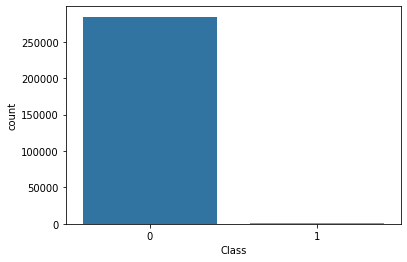

In [16]:
import seaborn as sns

sns.countplot(transaction_df.Class)

### EXERCISE: Split into train/test datasets

In this example, we'll want to evaluate the performance of a fraud classifier; training it on some training data and testing it on *test data* that it did not see during the training process. So, we'll need to split the data into separate training and test sets.

Complete the `train_test_split` function, below. This function should:
* Shuffle the transaction data, randomly
* Split it into two sets according to the parameter `train_frac`
* Get train/test features and labels
* Return the tuples: (train_features, train_labels), (test_features, test_labels)

In [6]:
from sklearn.model_selection import train_test_split as train_test_split_sklearn

In [7]:
# split into train/test
def train_test_split(transaction_df, train_frac= 0.7, seed=1):
    '''Shuffle the data and randomly split into train and test sets;
       separate the class labels (the column in transaction_df) from the features.
       :param df: Dataframe of all credit card transaction data
       :param train_frac: The decimal fraction of data that should be training data
       :param seed: Random seed for shuffling and reproducibility, default = 1
       :return: Two tuples (in order): (train_features, train_labels), (test_features, test_labels)
       '''
    
    # shuffle and split the data
    train_df, test_df = train_test_split_sklearn(
        transaction_df,  train_size=train_frac, random_state=seed, stratify=transaction_df["Class"])
    train_features = train_df.drop("Class", axis=1).values
    train_labels = train_df["Class"].values
    test_features = test_df.drop("Class", axis=1).values
    test_labels = test_df["Class"].values
    
    return (train_features, train_labels), (test_features, test_labels)


### Test Cell

In the cells below, I'm creating the train/test data and checking to see that result makes sense. The tests below test that the above function splits the data into the expected number of points and that the labels are indeed, class labels (0, 1).

In [8]:
# get train/test data
(train_features, train_labels), (test_features, test_labels) = train_test_split(transaction_df, train_frac=0.7)

In [9]:
# manual test

# for a split of 0.7:0.3 there should be ~2.33x as many training as test pts
print('Training data pts: ', len(train_features))
print('Test data pts: ', len(test_features))
print()

# take a look at first item and see that it aligns with first row of data
print('First item: \n', train_features[0])
print('Label: ', train_labels[0])
print()

# test split
assert len(train_features) > 2.333*len(test_features), \
        'Unexpected number of train/test points for a train_frac=0.7'
# test labels
assert np.all(train_labels)== 0 or np.all(train_labels)== 1, \
        'Train labels should be 0s or 1s.'
assert np.all(test_labels)== 0 or np.all(test_labels)== 1, \
        'Test labels should be 0s or 1s.'
print('Tests passed!')

Training data pts:  199364
Test data pts:  85443

First item: 
 [ 6.96270000e+04  1.13501057e+00 -6.63898044e-01  7.03924495e-01
  6.98714371e-02 -4.88154436e-01  1.31207778e+00 -8.97198118e-01
  4.63148217e-01 -4.78801156e-01  3.96879241e-01  2.68543975e-01
  7.52263678e-01  2.64092479e-01 -2.52977209e-01  5.15271757e-01
 -3.21151409e+00  1.64889698e+00 -1.29701211e+00 -2.24695806e+00
 -6.77938393e-01 -3.31487403e-01 -6.96435236e-02  1.83986712e-01
 -6.18678468e-01  8.90150908e-02  5.21418562e-01  8.63898814e-02
  4.78151042e-03  1.00000000e+00]
Label:  0

Tests passed!


In [10]:
# save train and test data
!mkdir -p data

import pickle

with open("data/train.pkl", "wb") as f:
    pickle.dump([train_features, train_labels], f)

with open("data/test.pkl", "wb") as f:
    pickle.dump([test_features, test_labels], f)

In [4]:
# load data

import pickle
with open("data/train.pkl", "rb") as f:
    train_features, train_labels = pickle.load(f)

with open("data/test.pkl", "rb") as f:
    test_features, test_labels = pickle.load(f)

---
# Modeling

Now that you've uploaded your training data, it's time to define and train a model!

In this notebook, you'll define and train the SageMaker, built-in algorithm, [LinearLearner](https://sagemaker.readthedocs.io/en/stable/linear_learner.html). 

A LinearLearner has two main applications:
1. For regression tasks in which a linear line is fit to some data points, and you want to produce a predicted output value given some data point (example: predicting house prices given square area).
2. For binary classification, in which a line is separating two classes of data and effectively outputs labels; either 1 for data that falls above the line or 0 for points that fall on or below the line.

<img src='notebook_ims/linear_separator.png' width=50% />

In this case, we'll be using it for case 2, and we'll train it to separate data into our two classes: valid or fraudulent. 

### EXERCISE: Create a LinearLearner Estimator

You've had some practice instantiating built-in models in SageMaker. All estimators require some constructor arguments to be passed in. See if you can complete this task, instantiating a LinearLearner estimator, using only the [LinearLearner documentation](https://sagemaker.readthedocs.io/en/stable/linear_learner.html) as a resource. This takes in a lot of arguments, but not all are required. My suggestion is to start with a simple model, utilizing default values where applicable. Later, we will discuss some specific hyperparameters and their use cases.

#### Instance Types

It is suggested that you use instances that are available in the free tier of usage: `'ml.c4.xlarge'` for training and `'ml.t2.medium'` for deployment.

In [5]:
# import LinearLearner
from sagemaker import LinearLearner

# instantiate LinearLearner
prefix = "creditcard"
output_path = "s3://{}/{}".format(bucket, prefix)

linear = LinearLearner(
    role=role,
    train_instance_count=1,
    train_instance_type="ml.c4.xlarge",
    predictor_type="binary_classifier",
    output_path=output_path,
    sagemaker_session=sagemaker_session,
    epochs=15
)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### EXERCISE: Convert data into a RecordSet format

Next, prepare the data for a built-in model by converting the train features and labels into numpy array's of float values. Then you can use the [record_set function](https://sagemaker.readthedocs.io/en/stable/linear_learner.html#sagemaker.LinearLearner.record_set) to format the data as a RecordSet and prepare it for training!

In [8]:
# create RecordSet of training data
train_x_np = train_features.astype("float32")
train_y_np = train_labels.astype("float32")

formatted_train_data = linear.record_set(train_x_np, labels=train_y_np)

### EXERCISE: Train the Estimator

After instantiating your estimator, train it with a call to `.fit()`, passing in the formatted training data.

In [7]:
%%time 
# train the estimator on formatted training data
linear.fit(formatted_train_data)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-02-02 06:17:39 Starting - Starting the training job...
2021-02-02 06:18:02 Starting - Launching requested ML instancesProfilerReport-1612246658: InProgress
......
2021-02-02 06:19:03 Starting - Preparing the instances for training.........
2021-02-02 06:20:28 Downloading - Downloading input data...
2021-02-02 06:21:05 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[02/02/2021 06:21:07 INFO 139963300570944] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto'

[2021-02-02 06:21:21.068] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 5, "duration": 6931, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.01722767475262359, "sum": 0.01722767475262359, "min": 0.01722767475262359}}, "EndTime": 1612246881.068551, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1612246881.068437}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.015239240243806311, "sum": 0.015239240243806311, "min": 0.015239240243806311}}, "EndTime": 1612246881.068643, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1612246881.068621}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0172185585175327

[2021-02-02 06:21:27.656] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 7, "duration": 6576, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.010570605186960805, "sum": 0.010570605186960805, "min": 0.010570605186960805}}, "EndTime": 1612246887.656914, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1612246887.656811}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.009007066189943246, "sum": 0.009007066189943246, "min": 0.009007066189943246}}, "EndTime": 1612246887.657011, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1612246887.656992}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0105638400154

[2021-02-02 06:21:40.321] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 11, "duration": 6636, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.007180885047768828, "sum": 0.007180885047768828, "min": 0.007180885047768828}}, "EndTime": 1612246900.321919, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1612246900.321822}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.006010866365241046, "sum": 0.006010866365241046, "min": 0.006010866365241046}}, "EndTime": 1612246900.322008, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1612246900.321987}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.007178189875

[2021-02-02 06:21:46.918] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 13, "duration": 6586, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.006549204619086568, "sum": 0.006549204619086568, "min": 0.006549204619086568}}, "EndTime": 1612246906.919126, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1612246906.918851}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.00552414006444078, "sum": 0.00552414006444078, "min": 0.00552414006444078}}, "EndTime": 1612246906.919221, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1612246906.919204}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.006547712069659

[2021-02-02 06:21:59.201] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 17, "duration": 6049, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0058648688301968215, "sum": 0.0058648688301968215, "min": 0.0058648688301968215}}, "EndTime": 1612246919.201627, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1612246919.201535}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004986512422561646, "sum": 0.004986512422561646, "min": 0.004986512422561646}}, "EndTime": 1612246919.201706, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1612246919.201688}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005864192

[2021-02-02 06:22:05.973] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 19, "duration": 6759, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005664908422297569, "sum": 0.005664908422297569, "min": 0.005664908422297569}}, "EndTime": 1612246925.973556, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1612246925.973298}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004834895577262993, "sum": 0.004834895577262993, "min": 0.004834895577262993}}, "EndTime": 1612246925.973642, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1612246925.973621}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005664194981

[2021-02-02 06:22:18.175] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 23, "duration": 6095, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005404178882963094, "sum": 0.005404178882963094, "min": 0.005404178882963094}}, "EndTime": 1612246938.175699, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 1612246938.175591}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0046659500422190185, "sum": 0.0046659500422190185, "min": 0.0046659500422190185}}, "EndTime": 1612246938.17581, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 1612246938.175788}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.00540380

[2021-02-02 06:22:30.907] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 27, "duration": 6592, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0052447850967771445, "sum": 0.0052447850967771445, "min": 0.0052447850967771445}}, "EndTime": 1612246950.907888, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 12}, "StartTime": 1612246950.90776}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004585791704343192, "sum": 0.004585791704343192, "min": 0.004585791704343192}}, "EndTime": 1612246950.907999, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 12}, "StartTime": 1612246950.907976}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.00524458

[2021-02-02 06:22:37.449] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 29, "duration": 6530, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005187534201085268, "sum": 0.005187534201085268, "min": 0.005187534201085268}}, "EndTime": 1612246957.449647, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 13}, "StartTime": 1612246957.449543}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004535136936597488, "sum": 0.004535136936597488, "min": 0.004535136936597488}}, "EndTime": 1612246957.449731, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 13}, "StartTime": 1612246957.449712}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0051873660


2021-02-02 06:23:06 Uploading - Uploading generated training model
2021-02-02 06:23:06 Completed - Training job completed
Training seconds: 150
Billable seconds: 150
CPU times: user 917 ms, sys: 35.8 ms, total: 953 ms
Wall time: 5min 43s


### EXERCISE: Deploy the trained model

Deploy your model to create a predictor. We'll use this to make predictions on our test data and evaluate the model.

In [8]:
%%time 
# deploy and create a predictor
linear_predictor = linear.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-------------------!CPU times: user 359 ms, sys: 18.2 ms, total: 377 ms
Wall time: 9min 32s


---
# Evaluating Your Model

Once your model is deployed, you can see how it performs when applied to the test data.

According to the deployed [predictor documentation](https://sagemaker.readthedocs.io/en/stable/linear_learner.html#sagemaker.LinearLearnerPredictor), this predictor expects an `ndarray` of input features and returns a list of Records.
> "The prediction is stored in the "predicted_label" key of the `Record.label` field."

Let's first test our model on just one test point, to see the resulting list.

In [9]:
# test one prediction
test_x_np = test_features.astype('float32')
result = linear_predictor.predict(test_x_np[0])

print(result)

[label {
  key: "predicted_label"
  value {
    float32_tensor {
      values: 0.0
    }
  }
}
label {
  key: "score"
  value {
    float32_tensor {
      values: 0.0002879130479414016
    }
  }
}
]


"0.0002879130479414016" means highly confident about prediction; "0.05" means highly unconfident.

### Helper function for evaluation


The provided function below, takes in a deployed predictor, some test features and labels, and returns a dictionary of metrics; calculating false negatives and positives as well as recall, precision, and accuracy.

In [13]:
# code to evaluate the endpoint on test data
# returns a variety of model metrics
def evaluate(predictor, test_features, test_labels, verbose=True):
    """
    Evaluate a model on a test set given the prediction endpoint.  
    Return binary classification metrics.
    :param predictor: A prediction endpoint
    :param test_features: Test features
    :param test_labels: Class labels for test data
    :param verbose: If True, prints a table of all performance metrics
    :return: A dictionary of performance metrics.
    """
    
    # We have a lot of test data, so we'll split it into batches of 100
    # split the test data set into batches and evaluate using prediction endpoint    
    prediction_batches = [predictor.predict(batch) for batch in np.array_split(test_features, 100)]
    
    # LinearLearner produces a `predicted_label` for each data point in a batch
    # get the 'predicted_label' for every point in a batch
    test_preds = np.concatenate([np.array([x.label['predicted_label'].float32_tensor.values[0] for x in batch]) 
                                 for batch in prediction_batches])
    
    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(test_labels, test_preds).sum()
    fp = np.logical_and(1-test_labels, test_preds).sum()
    tn = np.logical_and(1-test_labels, 1-test_preds).sum()
    fn = np.logical_and(test_labels, 1-test_preds).sum()
    
    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    
    # printing a table of metrics
    if verbose:
        print(pd.crosstab(test_labels, test_preds, rownames=['actual (row)'], colnames=['prediction (col)']))
        print("\n{:<11} {:.3f}".format('Recall:', recall))
        print("{:<11} {:.3f}".format('Precision:', precision))
        print("{:<11} {:.3f}".format('Accuracy:', accuracy))
        print()
        
    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn, 
            'Precision': precision, 'Recall': recall, 'Accuracy': accuracy}


### Test Results

The cell below runs the `evaluate` function. 

The code assumes that you have a defined `predictor` and `test_features` and `test_labels` from previously-run cells.

In [12]:
print('Metrics for simple, LinearLearner.\n')

# get metrics for linear predictor
metrics = evaluate(linear_predictor, 
                   test_features.astype('float32'), 
                   test_labels, 
                   verbose=True) # verbose means we'll print out the metrics


Metrics for simple, LinearLearner.



NameError: name 'evaluate' is not defined

## Delete the Endpoint

I've added a convenience function to delete prediction endpoints after we're done with them. And if you're done evaluating the model, you should delete your model endpoint!

In [16]:
# Deletes a precictor.endpoint
def delete_endpoint(predictor):
        try:
            boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)
            print('Deleted {}'.format(predictor.endpoint))
        except:
            print('Already deleted: {}'.format(predictor.endpoint))

In [13]:
# delete the predictor endpoint 
delete_endpoint(linear_predictor)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Deleted linear-learner-2021-02-02-06-24-48-686


---

# Model Improvements

The default LinearLearner got a high accuracy, but still classified fraudulent and valid data points incorrectly. Specifically classifying more than 30 points as false negatives (incorrectly labeled, fraudulent transactions), and a little over 30 points as false positives (incorrectly labeled, valid transactions). Let's think about what, during training, could cause this behavior and what we could improve.

**1. Model optimization**
* If we imagine that we are designing this model for use in a bank application, we know that users do *not* want any valid transactions to be categorized as fraudulent. That is, we want to have as few **false positives** (0s classified as 1s) as possible. 
* On the other hand, if our bank manager asks for an application that will catch almost *all* cases of fraud, even if it means a higher number of false positives, then we'd want as few **false negatives** as possible.
* To train according to specific product demands and goals, we do not want to optimize for accuracy only. Instead, we want to optimize for a metric that can help us decrease the number of false positives or negatives. 

<img src='notebook_ims/precision_recall.png' width=40% />
     
In this notebook, we'll look at different cases for tuning a model and make an optimization decision, accordingly.

**2. Imbalanced training data**
* At the start of this notebook, we saw that only about 0.17% of the training data was labeled as fraudulent. So, even if a model labels **all** of our data as valid, it will still have a high accuracy. 
* This may result in some overfitting towards valid data, which accounts for some **false negatives**; cases in which fraudulent data (1) is incorrectly characterized as valid (0).

So, let's address these issues in order; first, tuning our model and optimizing for a specific metric during training, and second, accounting for class imbalance in the training set. 


## Improvement: Model Tuning

Optimizing according to a specific metric is called **model tuning**, and SageMaker provides a number of ways to automatically tune a model.


### Create a LinearLearner and tune for higher precision 

**Scenario:**
* A bank has asked you to build a model that detects cases of fraud with an accuracy of about 85%. 

In this case, we want to build a model that has as many true positives and as few false negatives, as possible. This corresponds to a model with a high **recall**: true positives / (true positives + false negatives). 

To aim for a specific metric, LinearLearner offers the hyperparameter `binary_classifier_model_selection_criteria`, which is the model evaluation criteria for the training dataset. A reference to this parameter is in [LinearLearner's documentation](https://sagemaker.readthedocs.io/en/stable/linear_learner.html#sagemaker.LinearLearner). We'll also have to further specify the exact value we want to aim for; read more about the details of the parameters, [here](https://docs.aws.amazon.com/sagemaker/latest/dg/ll_hyperparameters.html).

I will assume that performance on a training set will be within about 5% of the performance on a test set. So, for a recall of about 85%, I'll aim for a bit higher, 90%.

In [6]:
# instantiate a LinearLearner
# tune the model for a higher recall
linear_recall = LinearLearner(role=role,
                              train_instance_count=1, 
                              train_instance_type='ml.c4.xlarge',
                              predictor_type='binary_classifier',
                              output_path=output_path,
                              sagemaker_session=sagemaker_session,
                              epochs=15,
                              # precision_at_target_recall—The model with the highest precision at a given recall target.
                              binary_classifier_model_selection_criteria='precision_at_target_recall', # target recall
                              target_recall=0.9) # 90% recall


train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Train the tuned estimator

Fit the new, tuned estimator on the formatted training data.

In [9]:
%%time 
# train the estimator on formatted training data
linear_recall.fit(formatted_train_data)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-02-04 06:35:10 Starting - Starting the training job...
2021-02-04 06:35:35 Starting - Launching requested ML instancesProfilerReport-1612420510: InProgress
......
2021-02-04 06:36:36 Starting - Preparing the instances for training.........
2021-02-04 06:38:09 Downloading - Downloading input data
2021-02-04 06:38:09 Training - Downloading the training image...
2021-02-04 06:38:37 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[02/04/2021 06:38:34 INFO 140613256566592] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_

[2021-02-04 06:38:53.597] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 7, "duration": 6102, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.010570605186960805, "sum": 0.010570605186960805, "min": 0.010570605186960805}}, "EndTime": 1612420733.597422, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1612420733.597319}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.009007066189943246, "sum": 0.009007066189943246, "min": 0.009007066189943246}}, "EndTime": 1612420733.597531, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1612420733.597513}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0105638400154

[2021-02-04 06:38:59.564] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 9, "duration": 5956, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.008297338653449437, "sum": 0.008297338653449437, "min": 0.008297338653449437}}, "EndTime": 1612420739.564243, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1612420739.564155}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.006985109788089541, "sum": 0.006985109788089541, "min": 0.006985109788089541}}, "EndTime": 1612420739.564346, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1612420739.564325}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0082947975427

[2021-02-04 06:39:12.490] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 13, "duration": 6105, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.006549204619086568, "sum": 0.006549204619086568, "min": 0.006549204619086568}}, "EndTime": 1612420752.490204, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1612420752.490102}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.00552414006444078, "sum": 0.00552414006444078, "min": 0.00552414006444078}}, "EndTime": 1612420752.490318, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1612420752.490294}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.006547712069659

[2021-02-04 06:39:18.606] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 15, "duration": 6104, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.006139530657523841, "sum": 0.006139530657523841, "min": 0.006139530657523841}}, "EndTime": 1612420758.606319, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1612420758.60625}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005178612362799333, "sum": 0.005178612362799333, "min": 0.005178612362799333}}, "EndTime": 1612420758.606411, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1612420758.606396}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0061382412706

[2021-02-04 06:39:30.113] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 19, "duration": 6008, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005664908422297569, "sum": 0.005664908422297569, "min": 0.005664908422297569}}, "EndTime": 1612420770.113613, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1612420770.113379}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004834895577262993, "sum": 0.004834895577262993, "min": 0.004834895577262993}}, "EndTime": 1612420770.113718, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1612420770.113698}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005664194981

[2021-02-04 06:39:42.197] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 23, "duration": 6101, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005404178882963094, "sum": 0.005404178882963094, "min": 0.005404178882963094}}, "EndTime": 1612420782.197635, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 1612420782.197531}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0046659500422190185, "sum": 0.0046659500422190185, "min": 0.0046659500422190185}}, "EndTime": 1612420782.197738, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 1612420782.197716}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0054038

[2021-02-04 06:39:54.561] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 27, "duration": 6204, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0052447850967771445, "sum": 0.0052447850967771445, "min": 0.0052447850967771445}}, "EndTime": 1612420794.562001, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 12}, "StartTime": 1612420794.561775}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004585791704343192, "sum": 0.004585791704343192, "min": 0.004585791704343192}}, "EndTime": 1612420794.5621, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 12}, "StartTime": 1612420794.562084}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005244589


2021-02-04 06:40:11 Uploading - Uploading generated training model[2021-02-04 06:40:00.385] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 29, "duration": 5813, "num_examples": 200, "num_bytes": 33493152}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005187534201085268, "sum": 0.005187534201085268, "min": 0.005187534201085268}}, "EndTime": 1612420800.385796, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 13}, "StartTime": 1612420800.385699}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004535136936597488, "sum": 0.004535136936597488, "min": 0.004535136936597488}}, "EndTime": 1612420800.385904, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 13}, "StartTime": 1612420800.385881}

#metrics {"Metrics": {"train_binary_classi


2021-02-04 06:40:39 Completed - Training job completed
ProfilerReport-1612420510: NoIssuesFound
Training seconds: 143
Billable seconds: 143
CPU times: user 883 ms, sys: 62.9 ms, total: 946 ms
Wall time: 5min 53s


### Deploy and evaluate the tuned estimator

Deploy the tuned predictor and evaluate it.

We hypothesized that a tuned model, optimized for a higher recall, would have fewer false negatives (fraudulent transactions incorrectly labeled as valid); did the number of false negatives get reduced after tuning the model?

In [10]:
%%time 
# deploy and create a predictor
recall_predictor = linear_recall.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-----------------!CPU times: user 322 ms, sys: 21.3 ms, total: 344 ms
Wall time: 8min 32s


In [14]:
print('Metrics for tuned (recall), LinearLearner.\n')

# get metrics for tuned predictor
metrics = evaluate(recall_predictor, 
                   test_features.astype('float32'), 
                   test_labels, 
                   verbose=True)

Metrics for tuned (recall), LinearLearner.

prediction (col)    0.0   1.0
actual (row)                 
0                 82795  2500
1                    14   134

Recall:     0.905
Precision:  0.051
Accuracy:   0.971



## Delete the endpoint 

As always, when you're done evaluating a model, you should delete the endpoint. Below, I'm using the `delete_endpoint` helper function I defined earlier.

In [17]:
# delete the predictor endpoint 
delete_endpoint(recall_predictor)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Deleted linear-learner-2021-02-04-06-41-03-867


---
## Improvement: Managing Class Imbalance

We have a model that is tuned to get a higher recall, which aims to reduce the number of false negatives. Earlier, we discussed how class imbalance may actually bias our model towards predicting that all transactions are valid, resulting in higher false negatives and true negatives. It stands to reason that this model could be further improved if we account for this imbalance.

To account for class imbalance during training of a binary classifier, LinearLearner offers the hyperparameter, `positive_example_weight_mult`, which is the weight assigned to positive (1, fraudulent) examples when training a binary classifier. The weight of negative examples (0, valid) is fixed at 1. 

### EXERCISE: Create a LinearLearner with a `positive_example_weight_mult` parameter

In **addition** to tuning a model for higher recall (you may use `linear_recall` as a starting point), you should *add* a parameter that helps account for class imbalance. From the [hyperparameter documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/ll_hyperparameters.html) on `positive_example_weight_mult`, it reads:
> "If you want the algorithm to choose a weight so that errors in classifying negative vs. positive examples have equal impact on training loss, specify `balanced`."

You could also put in a specific float value, in which case you'd want to weight positive examples more heavily than negative examples, since there are fewer of them.

In [ ]:
# instantiate a LinearLearner

# include params for tuning for higher recall
# *and* account for class imbalance in training data
linear_balanced = LinearLearner(role=role,
                              train_instance_count=1, 
                              train_instance_type='ml.c4.xlarge',
                              predictor_type='binary_classifier',
                              output_path=output_path,
                              sagemaker_session=sagemaker_session,
                              epochs=15,
                              # precision_at_target_recall—The model with the highest precision at a given recall target.
                              binary_classifier_model_selection_criteria='precision_at_target_recall', # target recall
                              target_recall=0.9, # 90% recall
                              positive_example_weight_mult="balanced"
                            ) 



### EXERCISE: Train the balanced estimator

Fit the new, balanced estimator on the formatted training data.

In [ ]:
%%time 
# train the estimator on formatted training data
linear_balanced.fit(formatted_train_data)

### EXERCISE: Deploy and evaluate the balanced estimator

Deploy the balanced predictor and evaluate it. Do the results match with your expectations?

In [ ]:
%%time 
# deploy and create a predictor
balanced_predictor = linear_balanced.deploy(
    initial_instance_count = 1,
    instance_type = "ml.t2.medium"
)

In [ ]:
print('Metrics for balanced, LinearLearner.\n')

# get metrics for balanced predictor
metrics = evaluate(balanced_predictor, 
                   test_features.astype('float32'), 
                   test_labels, 
                   verbose=True)

## Delete the endpoint 

When you're done evaluating a model, you should delete the endpoint.

In [ ]:
# delete the predictor endpoint 
delete_endpoint(balanced_predictor)

A note on metric variability: 

The above model is tuned for the best possible precision with recall fixed at about 90%. The recall is fixed at 90% during training, but may vary when we apply our trained model to a test set of data.

---
## Model Design

Now that you've seen how to tune and balance a LinearLearner. Create, train and deploy your own model. This exercise is meant to be more open-ended, so that you get practice with the steps involved in designing a model and deploying it.

### EXERCISE: Train and deploy a LinearLearner with appropriate hyperparameters, according to the given scenario

**Scenario:**
* A bank has asked you to build a model that optimizes for a good user experience; users should only ever have up to about 15% of their valid transactions flagged as fraudulent.

This requires that you make a design decision: Given the above scenario, what metric (and value) should you aim for during training?

You may assume that performance on a training set will be within about 5-10% of the performance on a test set. For example, if you get 80% on a training set, you can assume that you'll get between about 70-90% accuracy on a test set.

Your final model should account for class imbalance and be appropriately tuned. 

In [ ]:
%%time
# instantiate and train a LinearLearner

# include params for tuning for higher precision
# *and* account for class imbalance in training data
linear_precision = LinearLearner(role=role,
                                train_instance_count=1, 
                                train_instance_type='ml.c4.xlarge',
                                predictor_type='binary_classifier',
                                output_path=output_path,
                                sagemaker_session=sagemaker_session,
                                epochs=15,
                                binary_classifier_model_selection_criteria='recall_at_target_precision',
                                target_precision=0.9,
                                positive_example_weight_mult='balanced')


# train the estimator on formatted training data
linear_precision.fit(formatted_train_data)

In [ ]:
%%time 
# deploy and evaluate a predictor
precision_predictor = linear_precision.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

In [ ]:
print('Metrics for tuned (precision), LinearLearner.\n')

# get metrics for balanced predictor
metrics = evaluate(precision_predictor, 
                   test_features.astype('float32'), 
                   test_labels, 
                   verbose=True)

In [ ]:
## IMPORTANT
# delete the predictor endpoint after evaluation 
delete_endpoint(precision_predictor)

## Final Cleanup!

* Double check that you have deleted all your endpoints.
* I'd also suggest manually deleting your S3 bucket, models, and endpoint configurations directly from your AWS console.

You can find thorough cleanup instructions, [in the documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-cleanup.html).

---
# Conclusion

In this notebook, you saw how to train and deploy a LinearLearner in SageMaker. This model is well-suited for a binary classification task that involves specific design decisions and managing class imbalance in the training set.

Following the steps of a machine learning workflow, you loaded in some credit card transaction data, explored that data and prepared it for model training. Then trained, deployed, and evaluated several models, according to different design considerations!